In [166]:
import torch
import torch.nn as nn

In [167]:
from torch.utils.data import Dataset
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        self.len = self.X.shape[0]
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.len

In [168]:
class LinearReg(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(LinearReg,self).__init__()
        self.layer = nn.Linear(input_dim,output_dim)
        print(self.layer.weight)
        print(self.layer.bias)

    def forward(self,X):
        X = self.layer(X) # layer has the w and b (random at start)
        return X

In [72]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

First lets make data with some noise and see the effect on loss

In [169]:
X, y = make_regression(n_samples= 1000, n_features= 2, n_informative= 2, n_targets= 1, noise= 20, random_state=13)

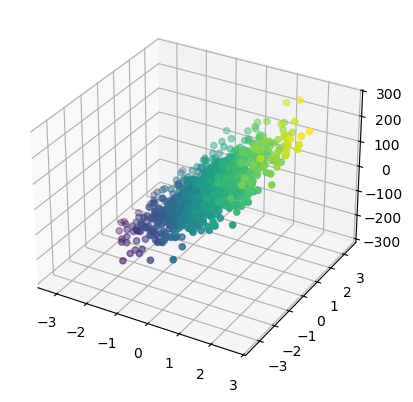

In [170]:
import matplotlib.pyplot as plt
ax = plt.axes(projection = '3d')
ax.scatter3D(X[:,0],X[:,1],y,c=y)

In [171]:
X_train , X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=13)

In [173]:
traindata = Data(X_train,y_train)
testdata = Data(X_test,y_test)

In [175]:
from torch.utils.data import DataLoader
batch_size = 64
num_workers = 0

train_loader = DataLoader(
    traindata,
    batch_size = batch_size, 
    shuffle = True, 
    num_workers = num_workers)

In [177]:
epochs = 100
lr = 0.01
X_dim = X_train.shape[1]
y_dim = y_train.shape[1] if len(y_train.shape) > 1 else 1
model = LinearReg(X_dim,y_dim)
criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(),lr=lr)

Parameter containing:
tensor([[-0.2008,  0.2499]], requires_grad=True)
Parameter containing:
tensor([0.0346], requires_grad=True)


In [185]:
for epoch in range(epochs):
    running_loss = 0.0
    for i,(xi, yi) in enumerate(train_loader):
        outputs = model(xi)
        yi = yi.view(-1,1) # done to match the output shape
        
        loss = criterion(outputs,yi)
        
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad

        # optimizer.step()
        running_loss += loss.item()
    if not ((epoch + 1) % (epochs // 10)):
        print(f'Epochs:{epoch + 1:5d} | ' \
            f'Batches per epoch: {i + 1:3d} | ' \
            f'Loss: {running_loss / (i + 1):.10f}')

Epochs:   10 | Batches per epoch:  13 | Loss: 426.3284184383
Epochs:   20 | Batches per epoch:  13 | Loss: 428.7124774639
Epochs:   30 | Batches per epoch:  13 | Loss: 430.6507615309
Epochs:   40 | Batches per epoch:  13 | Loss: 426.8461022010
Epochs:   50 | Batches per epoch:  13 | Loss: 432.7244591346
Epochs:   60 | Batches per epoch:  13 | Loss: 422.1137155386
Epochs:   70 | Batches per epoch:  13 | Loss: 427.5406212440
Epochs:   80 | Batches per epoch:  13 | Loss: 432.1889155461
Epochs:   90 | Batches per epoch:  13 | Loss: 425.2360910269
Epochs:  100 | Batches per epoch:  13 | Loss: 425.3310992901


In [186]:
ypred = model(torch.FloatTensor(X_test))

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [187]:
r2_score(y_test,ypred.detach().numpy())

0.9536791951888914

In [188]:
mean_squared_error(y_test,ypred.detach().numpy())

404.11712309492447

In [189]:
mean_absolute_error(y_test,ypred.detach().numpy())

15.56105311451825

#### Here we observe that even though r2 score is good, MSE is not
Lets try using the SGDRegressor and see that we've got

In [193]:
from sklearn.linear_model import SGDRegressor
sgd = SGDRegressor()
sgd.fit(X_train,y_train)
ypred = sgd.predict(X_test)

In [194]:
r2_score(y_test,ypred)

0.9537423809684448

In [195]:
mean_absolute_error(y_test,ypred)

15.559407698712102

In [196]:
mean_squared_error(y_test,ypred)

403.56587068129016

#### That's surprising bcs both things gave same results (obvious bcs of how things are implemented)

#### Why such a bad MSE even though good R2 score
- MSE relies on the mean squared diff of actual val and predicted value
- Now see that **we have noise in the data**, and due to that noise there are many pts which dont lie on the best fit curve and those pts produce the error and when those are penalized heavily and hence the more value
- Try **noise = 0 and then see this would give minial MSE**

#### Why MSE is sensitive to outliers but MAE is not
-  We just made a practical view that MSE squares those outliers and gives a very big value, which is why it's sensitive to outliers
-  MAE on the other hand doesn't sq terms, so is good for handling outliers (but not used much bcs its non differentiable nature)

#### So what to do?
- The noise and the points contribute to the loss
- Now, if we can bring the point and noise under a common scale, a normalized scale, then we can tackle the **problem of exploding gradients**
- To do this, we use the StandardScaler

In [197]:
from sklearn.preprocessing import StandardScaler
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

In [198]:
traindata = Data(X_train,y_train)
testdata = Data(X_test,y_test)

In [199]:
from torch.utils.data import DataLoader
batch_size = 64
num_workers = 0

train_loader = DataLoader(
    traindata,
    batch_size = batch_size, 
    shuffle = True, 
    num_workers = num_workers)

In [200]:
epochs = 100
lr = 0.01
X_dim = X_train.shape[1]
y_dim = y_train.shape[1] if len(y_train.shape) > 1 else 1
model = LinearReg(X_dim,y_dim)
criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(),lr=lr)

Parameter containing:
tensor([[ 0.6248, -0.2069]], requires_grad=True)
Parameter containing:
tensor([-0.0234], requires_grad=True)


In [201]:
for epoch in range(epochs):
    running_loss = 0.0
    for i,(xi, yi) in enumerate(train_loader):
        outputs = model(xi)
        yi = yi.view(-1,1) # done to match the output shape
        
        loss = criterion(outputs,yi)
        
        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            for param in model.parameters():
                param -= lr * param.grad

        # optimizer.step()
        running_loss += loss.item()
    if not ((epoch + 1) % (epochs // 10)):
        print(f'Epochs:{epoch + 1:5d} | ' \
            f'Batches per epoch: {i + 1:3d} | ' \
            f'Loss: {running_loss / (i + 1):.10f}')

Epochs:   10 | Batches per epoch:  13 | Loss: 0.0545739093
Epochs:   20 | Batches per epoch:  13 | Loss: 0.0511115655
Epochs:   30 | Batches per epoch:  13 | Loss: 0.0505700421
Epochs:   40 | Batches per epoch:  13 | Loss: 0.0517972255
Epochs:   50 | Batches per epoch:  13 | Loss: 0.0523927965
Epochs:   60 | Batches per epoch:  13 | Loss: 0.0513264508
Epochs:   70 | Batches per epoch:  13 | Loss: 0.0517652235
Epochs:   80 | Batches per epoch:  13 | Loss: 0.0513209597
Epochs:   90 | Batches per epoch:  13 | Loss: 0.0510555044
Epochs:  100 | Batches per epoch:  13 | Loss: 0.0514471282


As we can see, the MSE is very minimal now with the same performance

In [202]:
ypred = model(torch.FloatTensor(X_test))

In [203]:
r2_score(y_test,ypred.detach().numpy())

0.9537038402756167

### What can be further done?
We used manual parameter updation using formula. We can manipulate that too by using Optimizers yielding better results